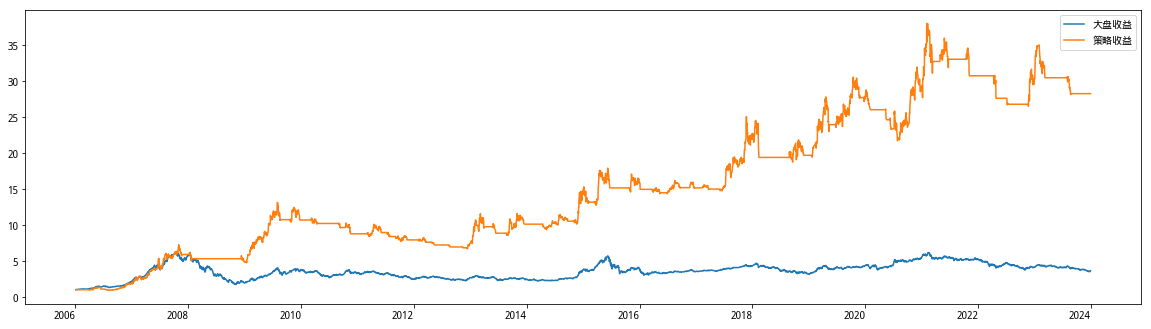

累计收益率                        27.2409
年化收益率                       0.210393
超额收益率                        24.5964
Alpha                     -0.0617587
Beta                         6.32279
IR                         0.0152546
最大回撤                        0.488305
最大回撤开始                    2009-08-03
最大回撤结束                    2012-12-14
夏普                          0.812595
交易次数                              47
持仓总天数                           3293
平均持仓天数    70 days 01:31:54.893617021
盈利次数                              18
亏损次数                              29
胜率                          0.382979
盈亏比                          2.14297
dtype: object

In [4]:
"""
关闭警告日志
import warnings
warnings.simplefilter("ignore")

"""

from jqdata import *

import time
from datetime import datetime,timedelta
from dateutil.relativedelta import relativedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import logging

def prof_summary(profiles,orders=None,benchmark=None):
#     value_pct=pd.Series(self.values,self.times).pct_change()
    value_pct=profiles.pct_change()
    value_ret=(1+value_pct).cumprod()

    ret={}

    ret['累计收益率']=value_ret.iloc[-1]-1
    ret['年化收益率']=(1+ret['累计收益率'])**(250/len(value_ret)) - 1

    if benchmark is not None:
        ret['超额收益率']=value_ret.iloc[-1]-benchmark[-1]
        cm=np.cov(value_ret.dropna(),benchmark.dropna())
        beta=cm[0,1] / cm[1,1]
        Rp=ret['年化收益率']
        Rf=0.04
        Rm=benchmark.iloc[-1]**(250/len(benchmark)) - 1
        alpha=Rp-(Rf+beta*(Rm-Rf))
        ret['Alpha']=alpha
        ret['Beta']=beta

        Dt=(value_ret-benchmark).std()
        ir=(Rp-Rm)/Dt
        ret['IR']=ir

    max_nv=np.maximum.accumulate(np.nan_to_num(value_ret))
    t=value_ret / max_nv
    mdd=-np.min(t - 1)
    ret['最大回撤']=mdd
    ret['最大回撤开始']=t[t==1].loc[:t.idxmin()].index[-1]
    ret['最大回撤结束']=t.idxmin()

    ret['夏普']=np.mean(value_pct)/np.nanstd(value_pct,ddof=1)*np.sqrt(250)

    if orders is not None:

        temp_code_d={} ## code:(建仓时间,pos,买入金额累计,卖出金额累计)
        trades=[] ## code,start,end,net_return
        profit_amount=0
        loss_amount=0
        for dt,code,p,a in orders:
            if code not in temp_code_d:
                temp_code_d[code]=(dt,0,0,0)
            start,pos,buy_sum,sell_sum=temp_code_d[code]

            amount=a*p

            if a>0:
                buy_sum += amount
            elif a<0:
                sell_sum += -amount

            pos += a

            if pos<=0:
                y=sell_sum-buy_sum
                if y>=0:
                    profit_amount += y
                else:
                    loss_amount += -y
                trades.append((code,start,dt,y))
                del temp_code_d[code]
            else:
                temp_code_d[code]=(start,pos,buy_sum,sell_sum)

        df=pd.DataFrame(data=trades,columns=['code','start','end','net_return'])

        ret['交易次数']=df.shape[0]
        ret['持仓总天数']=0 if df.empty else sum((df['end']-df['start']).dt.days) # 直接调用sum会造成数据溢出
        ret['平均持仓天数']=0 if df.empty else (df['end']-df['start']).mean()
        ret['盈利次数']=0 if df.empty else df[df['net_return']>0].shape[0]
        ret['亏损次数']=0 if df.empty else df[df['net_return']<0].shape[0]
        ret['胜率']=np.inf if df.empty else ret['盈利次数']/ret['交易次数'] if ret['交易次数']>0 else None
        ret['盈亏比']=profit_amount/loss_amount if loss_amount>0 else np.inf

    return pd.Series(ret)



def is_the_trade_day_of_month(day:datetime,num:int):
    start=datetime(day.year,day.month,1)
    end=start+relativedelta(months=1)-relativedelta(days=1)
    days=get_trade_days(start,end)
    return day==days[num]

class _Context:
    def __init__(self,fq='pre',ignore_high_limit=False,ignore_low_limit=False): #fq="pre",None,"post"
        self.pre_time=None
        self.current_time=None
        self.pre_day=None
        self.current_day=None
        self.fq=fq
        ## 下面两个开关可以决定是否忽略涨跌停无法交易的限制如果打开可能引起错误的交易行为!!
        self.ignore_high_limit=ignore_high_limit
        self.ignore_low_limit=ignore_low_limit

    ## 判断给定日期是否是当月第num个交易日
    def is_the_trade_day_of_month(self,num,day=None):
        if day is None:
            day=self.current_time
        return is_the_trade_day_of_month(day,num)


class Position:
    def __init__(self,context,code,amount,price):
        self.context=context
        self.code=code
        self.init_time=self.context.current_time
        self.last_time=self.context.current_time
        self.amount=amount
        self.avg_cost=price

    def update(self,amount,price):
        self.avg_cost=self.amount*self.avg_cost+amount*price
        self.amount += amount
        self.last_time=self.context.current_time

    def __repr__(self):
        return str(self.amount)+' '+str(self.price)

    @property
    def price(self):
        p_df=get_price(self.code,count=1,end_date=self.context.current_time,
                         frequency='1m',skip_paused=False,panel=False,fq=self.context.fq)
        if p_df.empty:
            raise Exception(f'{self.context.current_time} {self.code} read current price failed.')
        return p_df.iloc[0].open ## 默认开盘买入

    @property
    def value(self):
        try:
            return self.amount*self.price   
        except:
            return 0


class _Profile:
    def __init__(self,context,init_cash):
        self.context=context # 上下文_Context
        self.init_cash=init_cash

        self.positions={} #持仓 code:Position
        self.values=[] #每日市值
        self.times=[]
        self.a_cash=self.init_cash # 可用现金
        self.orders=[] #交易记录

    @property
    def total_value(self):
        return self.values[-1] if self.values else self.a_cash

    ## 每个交易日后执行
    def update_value(self):
        day=self.context.current_day
        self.times.append(day)

        end_stocks=[code for code in self.positions if get_security_info(code).end_date<day]
        for code in end_stocks:
            del self.positions[code] # 这里模拟已经退市的股票价值直接归零
            logging.warning(f"{code} delisted. {day} ")

        if self.positions:
            self.values.append(sum([pos.value for code,pos in self.positions.items()])+self.a_cash)
#             print(day,self.values[-1],self.a_cash)
        else:
            self.values.append(self.a_cash)#self.values[-1] if self.values else self.a_cash)

    def buy(self,code,amount=None,cash=None):
        day=self.context.current_time

        if cash is None:
            cash=self.a_cash
        if cash>self.a_cash:
            logging.warning(f"Buy {code} failed. Cash {cash}> avable {self.a_cash}. {day} ")
            return False

        p_df=get_price(code,count=1,end_date=day,frequency='1m',panel=False,fields=['open','close','high_limit','low_limit','paused'],fq=self.context.fq)
        if p_df.empty or p_df.iloc[0].paused:
            logging.warning(f"Buy {code} failed. Stock is paused.  {day} ")
            return False

        price=p_df.iloc[0].open ## 默认开盘买入

        if not self.context.ignore_high_limit and price>=p_df.iloc[0].high_limit:
            logging.warning(f"Buy {code} failed. {price}>=high_limit. {day} ")
            return False

        if amount is None:
            a=cash/price
            amount=a-a%100

        if amount<100:
            logging.warning(f"Buy {code} failed {amount}<100. {day} ")
#             print('buy','amount<100',code)
            return False

        if code not in self.positions:
            self.positions[code]=Position(
                self.context,
                code,
                amount,price
            )
        else:
            self.positions[code].update(amount,price)

        self.orders.append((day,code,price,amount))

        self.a_cash -= amount*price

        return True

    def sell(self,code,amount=None):
        day=self.context.current_time

        p_df=get_price(code,count=1,end_date=day,frequency='1m',panel=False,fields=['open','close','high_limit','low_limit','paused'],fq=self.context.fq)
        if p_df.empty or p_df.iloc[0].paused:
            logging.warning(f"Buy {code} failed. Stock is paused.  {day} ")
            return False

        price=p_df.iloc[0].open ## 默认开盘买入

        if not self.context.ignore_low_limit and price<=p_df.iloc[0].low_limit:
            logging.warning(f"Sell {code} failed {price}<=low_limit. {day} ")
            return False

        if code not in self.positions:
            logging.warning(f"Sell {code} failed not in position. {day} ")
            return False

        if amount is None: # 卖空
            amount=self.positions[code].amount

        if amount<100:
            logging.warning(f"Sell {code} failed {amount}<100. {day} ")
#             print('sell','amount<100',code)
            return False

        self.positions[code].update(-amount,price)

        if not self.positions[code].amount:
            del self.positions[code]

        self.orders.append((day,code,price,-amount))
        self.a_cash += amount*price

        return True

    def buy_all(self,buy_l):
        buys=[]

        if not buy_l:
            return buys

        cash=self.a_cash/len(buy_l)

        for code in buy_l:
            try:
                if self.buy(code,cash=cash):
                    buys.append(code)
            except Exception as ex:
                logging.error(str(ex))

        return buys


    def sell_all(self):
        sell_l=list(self.positions.keys())

        sells=[]
        for code in sell_l:
            if self.sell(code):
                sells.append(code)

        return sells

    def sell_when(self,checker):

        sell_l=[]
        for code,pos in self.positions.items():
            try:
                if checker(code,pos):
                    sell_l.append(code)
            except Exception as ex:
                logging.error(str(ex))

        sells=[]
        for code in sell_l:
            if self.sell(code):
                sells.append(code)

        return sells

    def swap(self,stocks):
        sells=[]
        buys=[]

        sell_l=set(self.positions).difference(stocks)
        for code in sell_l:
            if self.sell(code):
                sells.append(code)

        buy_l=set(stocks).difference(self.positions)
        if not stocks:
            return sells,buys

        cash=self.a_cash/len(buy_l)

        for code in buy_l:
            try:
                if self.buy(code,cash=cash):
                    buys.append(code)
            except Exception as ex:
                logging.error(str(ex))

        return sells,buys


    def summary(self,benchmark=None):
        return prof_summary(pd.Series(self.values,self.times)
                           ,orders=self.orders
                           ,benchmark=benchmark)

def __day2time(day,H,M,S):
    return datetime(day.year,day.month,day.day,H,M,S)

def trade_daily(trade_cb,start,end,init_cash,fq='pre',ignore_high_limit=False,ignore_low_limit=False):
    ctx=_Context(fq=fq,ignore_high_limit=ignore_high_limit,ignore_low_limit=ignore_low_limit)
    prof=_Profile(ctx,init_cash)
    all_days=get_all_trade_days()
    if not isinstance(all_days,list):
        all_days=all_days.tolist()
    days=get_trade_days(start,end)

    i=all_days.index(days[0])

    ctx.pre_day=all_days[i-1]
    ctx.pre_time=__day2time(all_days[i-1],9,30,0)
    for day in days:
        ctx.current_time=__day2time(day,9,30,0)
        ctx.current_day=day

        trade_cb(ctx,prof)

        prof.update_value()

        ctx.pre_time=ctx.current_time
        ctx.pre_day=ctx.current_day

    return prof

def trade_minutely(trade_cb,start,end,init_cash,fq='pre',ignore_high_limit=False,ignore_low_limit=False):
    ctx=_Context(fq=fq,ignore_high_limit=ignore_high_limit,ignore_low_limit=ignore_low_limit)
    prof=_Profile(ctx,init_cash)
    all_days=get_all_trade_days()
    if not isinstance(all_days,list):
        all_days=all_days.tolist()
    days=get_trade_days(start,end)

    i=all_days.index(days[0])

    ctx.pre_day=all_days[i-1]
    ctx.pre_time=__day2time(all_days[i-1],9,30,0)
    for day in days:
        ctx.current_time=__day2time(day,9,30,0)
        ctx.current_day=day

        while ctx.current_time<=__day2time(day,11,30,0):
            trade_cb(ctx,prof)
            ctx.pre_time=ctx.current_time
            ctx.current_time += timedelta(minutes=1)

        ctx.current_time=__day2time(day,13,0,0)
        while ctx.current_time<=__day2time(day,15,0,0):
            trade_cb(ctx,prof)
            ctx.pre_time=ctx.current_time
            ctx.current_time += timedelta(minutes=1)

        prof.update_value()

        ctx.pre_day=ctx.current_day

    return prof


def _get_time_pretty(ms):
    if ms<1000:
        return f"{ms:0.1f}ms"
    s=ms/1000
    if s<60:
        return f"{s:0.1f}s"
    m=s/60
    if m<60:
        return f"{m:0.1f}m"
    h=m/60
    if h<24:
        return f"{h:0.1f}h"
    d=h/24
    return f"{d:0.1f}d"


## 比较多个策略
def compare_multi_strategy(ref,stragety_class,start,end,params,log=False,init_cash=10000000,fq='pre',trade_func=trade_daily,ignore_high_limit=False,ignore_low_limit=False):
    p_df=get_price(ref,start,end,panel=False)
    ref_pct=p_df.close.pct_change() ## 大盘收益
    m_ret=(1+ref_pct).cumprod()

    m_ret.plot(label='大盘')

    prof_l=[]
    summarys={}
    for i in params:
        name=i[0]
        t=time.time()
        prof=trade_func(stragety_class(*i[1:]),start,end,init_cash,fq,ignore_high_limit=ignore_high_limit,ignore_low_limit=ignore_low_limit)
        t_delta=time.time()-t
        prof_l.append((name,prof))
        summarys[name]=prof.summary(benchmark=m_ret)
        if log:
            print(datetime.now(),name,summarys[name]['累计收益率'],_get_time_pretty(t_delta/1000))        
        (1+pd.Series(prof.values,prof.times).pct_change()).cumprod().plot(label=name)

    plt.legend()
    plt.show()

    display(pd.DataFrame(summarys))

    return prof_l


## 定义策略函数，除了策略函数也可以定义策略类，后面会展示
## 双均线策略
def double_ma(
    ctx,  #上下文，类似聚宽的context，具体见TinyBacktest代码_Context类
    prof  #交易内容，见_Profile类
    ):
    ## 取上一个交易日期包含具体时间
    day = ctx.pre_time
    
    code = '000001.XSHE'
    price = get_price(code, count=121, end_date=day, panel=False)
    ma120 = price['close'].rolling(56).mean().dropna()
    ma60 = price['close'].rolling(6).mean().dropna()
    
    if ma60[-2]<ma120[-2] and ma60[-1]>ma120[-1]:
        prof.buy(code)
    elif ma60[-2]>ma120[-2] and ma60[-1]<ma120[-1]:
        prof.sell(code)
#运行策略，trade_daily在每个交易日开盘时调用mv_strategy
prof = trade_daily(double_ma, '2006-1-1', '2024-1-1', 10000000)
#绘制策略收益曲线图
m_df = get_price('000300.XSHG', '2006-1-1', '2024-1-1', panel=False)
m_ret = (1+m_df.close.pct_change()).cumprod()
x_ret = (1+pd.Series(prof.values, prof.times).pct_change().dropna()).cumprod()
plt.figure(figsize=(20,6))
m_ret.plot(label='大盘收益')
x_ret.plot(label='策略收益')
plt.legend()
plt.show()
#显示风险指标
prof.summary(benchmark=m_ret)